## 시계열 분석 정상성 확인 요약

평균 일정 x -> 차분

(분산 일정 x -> 차분 이전에 로그 변환 수행 np.log로 변환 가능)

평균, 분산 일정에 대한 시각화는 나와도 검증은 출제 안됨(모델 잔차쪽도 마찬가지)

1. 시계열 데이터 불러와서 데이터 가공

2. 정규성, 이분산성 시각화 필요한지 확인 후 필요하면 수행

3. ACF, PACF 시각화 adf test로 비정상 시계열 확인

4. 차분 등 수행 후, 3번 과정과 비교하여 정상 시계열 변환 완료 확인

## 시계열 분석용 데이터 가공 및 시각화

해당 데이터는 2020년 3월부터 2021년 3월 2일까지의 비트코인 가격에 대한 데이터 입니다.

날짜는 str 타입이고, price는 float 타입입니다.

데이터는 https://www.blockchain.com/ko/charts/market-price?timespan=60days 링크로 이동하신 다음에

export data를 하셔서 csv 파일로 받으시면 됩니다.

(파일을 csv로 했는데 파일 포맷이 csv가 아니면 이름 바꾸기로 .csv 붙이고 진행해주세요)

데이터를 불러온 다음에, 날짜가 str 타입이므로 

pandas의 to_datetime을 이용하여서 pandas의 Timestamp 타입으로 변화시켜 줍니다.

그 이후, day 컬럼을 index로 해주면 바로 아래와 같은 형태로 바뀌게 됩니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt

series = pd.read_csv('market-price.csv', header=0, names=['day','price'])

series['day'] = pd.to_datetime(series['day']) #str to pandas Timestamp 

series.index = series['day']
series.set_index('day',inplace=True) #index로 변환

series.tail()

,price
day,
2021-02-26,46800.42
2021-02-27,46340.31
2021-02-28,46155.87
2021-03-01,45113.92
2021-03-02,49618.43


그래프를 그려보면 다음과 같이 나오게 되는데,

그래프만 보고 정상 시계열인지 아닌지 근거를 제시하면 안 된다.

정상 시계열인지 보려면 평균, 분산이 일정한 것이 근거인데, 이 단계에서는 이 둘을 검증하지 않는다.

19회에서도 정규성, 이분산성 시각화를 하는 것이 문제로 나왔지, 검증 하라고 나온 적은 없다.

일단 시각화 하려면 다음과 같이 진행하면 된다.

핵심은 rolling 안에 interval을 넣고 평균과 분산을 구한 다음에 그것을 plot에 그리면 된다.

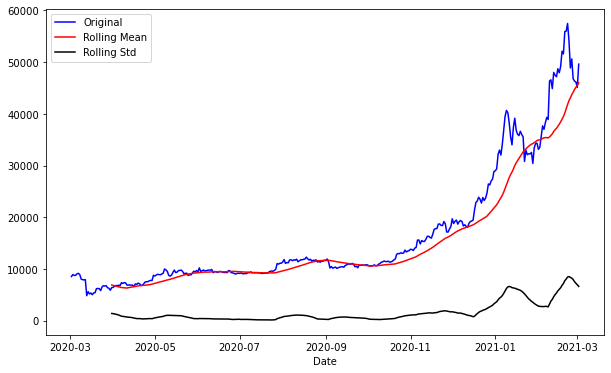

In [2]:
#series.plot()

def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()
    
plot_rolling(series, 30)

평균과 분산이 일정한지 확인해본 결과, 평균은 일단 꾸준히 상승하고 있으며,

분산도 마지막에는 값이 올라가는 것을 볼 수 있다.

추세요인, 계절요인, 불규칙 요인은 이제 아래와 같이, seasonal_decompose를 불러와서 그리면 된다

<function matplotlib.pyplot.show(close=None, block=None)>

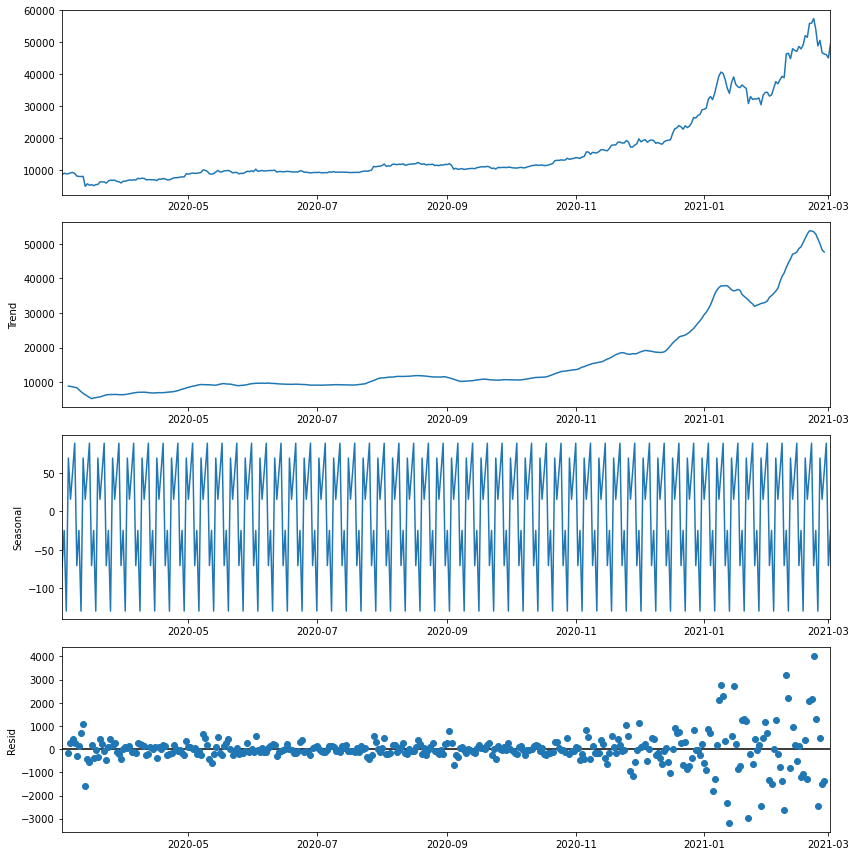

In [3]:
#관측값, 추세, 계절, 불규칙요인
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = [12, 12]

result = seasonal_decompose(series, model='additive')
result.plot()
plt.show

result.observed, result.trend, result.seasonal, result.resid로 각 그래프의 실제 값을 볼 수 있고

result.observed - result.seasonal와 같은 방식으로 필요하면 계절요인 제거 등을 할 수 있다.

ADP에서는 해당 요인들을 분석하는 part는 최근에 출제 된 적이 없는 것으로 보인다.

SARIMA가 나온 적은 있지만, 이 단계에서 고민할 파트는 아니다.

핵심은 정상성을 파악하는 것과 그것에 대한 근거이다.

그렇기 때문에, 다음 파트에서 근거를 명확히 제시하여야 한다.

## 시계열 정상성 여부 분석

평균과 분산이 일정한지 각각 검증 하면 좋긴 하지만 그건 ADP에서 나온 적 없다.

그렇기 때문에, 정상 시계열인지 검증하는 두 가지 방법을 소개하려 한다.

하나는 kpss test이고 나머지 하나는 ADF test이다. 추천 하자고 한 다면, ADF test를 추천한다.

kpss test는 혹시라도 몰라서 넣어놓았다. (시험에 뜬금포로 SARIMA도 넣는 사람들이라 혹시 모른다.) 

kpss test의 귀무가설은 해당 시계열이 정상 시계열이다. 이고

ADF test의 귀무가설은 해당 시계열이 비정상 시계열이다. 이다.

딱 정 반대의 가설로 검증을 진행한다.

In [4]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""} stationary')
    
kpss_test(series)

KPSS Statistic: 1.539780516968797
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not  stationary


C:\Users\bluemumin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


KPSS를 먼저 살펴본 결과, pvalue가 0.01수준이므로 귀무가설을 기각하고, 비정상 시계열이라는 대립 가설을 채택한다.

정상성을 나타내지 않는 시계열을 찾아낼 때 데이터의 시간 그래프를 살펴보는 것만큼, ACF 그래프도 유용합니다. 

정상성을 나타내지 않는 데이터에서는 ACF가 느리게 감소하지만, 

정상성을 나타내는 시계열에서는, ACF가 비교적 빠르게 0으로 떨어질 것입니다.

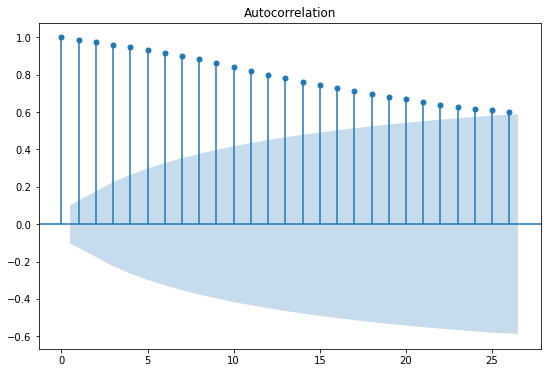

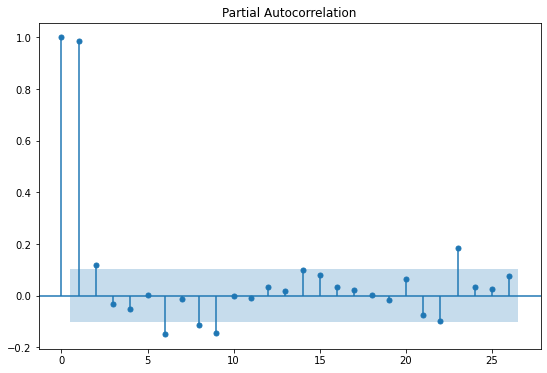

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize'] = [9, 6]
plot_acf(series)
plot_pacf(series)
plt.show()

위에서는 ACF가 천천히 감소하므로, 시각화 이후 근거로 ACF 값이 느리게 감소함을 제시하면 된다.

즉 비정상 시계열이므로, 조치가 필요하다는 것을 의미하고, 그렇기 때문에 차분을 통해서 정상 시계열로 변경 시켜준다.

KPSS Statistic: 0.49597946810359883
p-value: 0.042572191868558824
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not  stationary
None
-------------------------


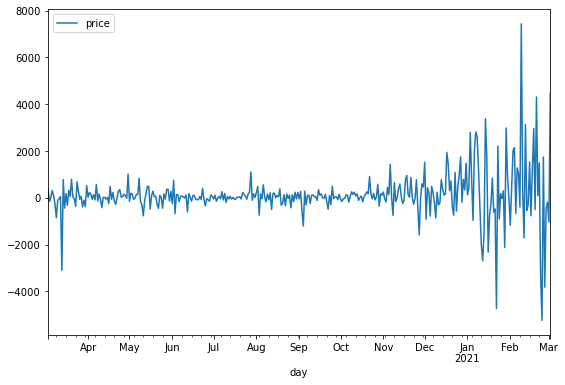

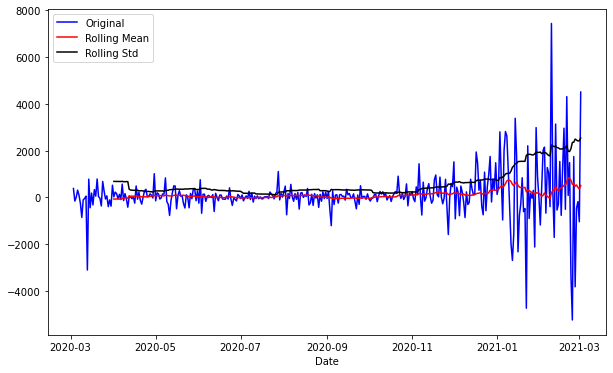

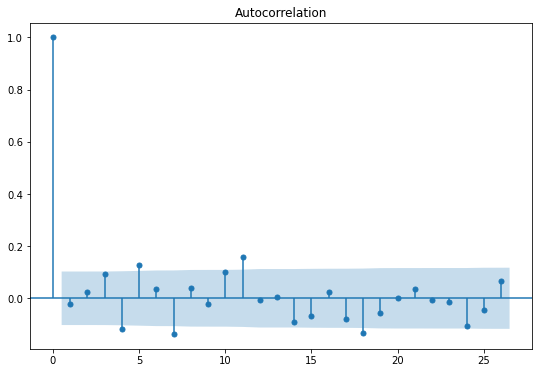

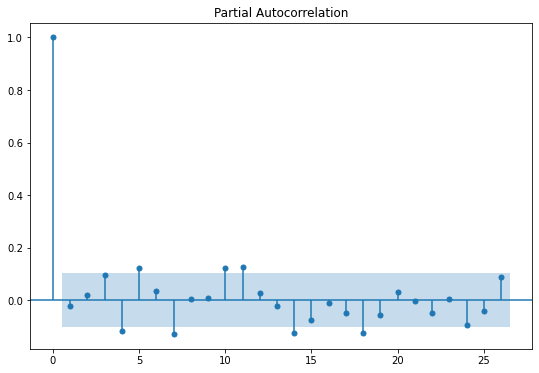

In [6]:
diff_1=series.diff(periods=1).iloc[1:] #차분1

print(kpss_test(diff_1))
print("-------------------------")
diff_1.plot()

plot_rolling(diff_1, 30)

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

1차 차분을 진행한 이후, kpss test, 평균 분산 일정 여부 시각화,

ACF, PACF를 시각화 한 결과이다.

이전과는 다르게 ACF 값이 확 감소하였고,

평균은 일정하고 분산도 거의 일정하지만 살짝 올라온 모습을 볼 수 있다.

로그 변환을 수행해도 되지만, 이번에는 생략하도록 하겠다. np.log만 더 추가해주면 되는 것이고

이번에 하려는 것은 전체 과정에 대한 것이기 때문이다.

마지막으로 kpss test 보다 더 추천하는 adf test이다.

귀무가설이 비정상 시계열이다 임을 잊으면 안된다.

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(series)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

result = adfuller(diff_1)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.10f}')

원 데이터 ADF Statistic: 1.976
원 데이터 p-value: 0.999
1차 차분 ADF Statistic: -5.660
1차 차분 p-value: 0.0000009417


원 데이터에서의 pvalue가 0.999이므로, 귀무가설을 채택하고(비정상 시계열)

차분을 수행한 이후의 pvalue가 0.001보다 작으므로 대립가설을 채택한다.(정상시계열)